# 2장 서울시 범죄 현황 분석

In [1]:
import numpy as np
import pandas as pd
import time
import re

# An importlib package installable from any python version
import importlib

# A Fast, Extensible Progress Bar for Python and CLI
from tqdm import tqdm

## 2-2 pandas를 이용하여 데이터 정리하기

In [2]:
crime = pd.read_csv('./data/crime_in_seoul_2019.txt', 
    sep='\t', 
    thousands=',', 
    encoding='utf-8', 
    names=['기간', '구별', '발생합계', '검거합계', '살인발생', '살인검거', '강도발생', '강도검거', '강간발생', '강간검거', '절도발생', '절도검거', '폭력발생', '폭력검거'],
    usecols=['기간', '구별', '살인발생', '살인검거', '강도발생', '강도검거', '강간발생', '강간검거', '절도발생', '절도검거', '폭력발생', '폭력검거'],
    skiprows=[0,1,2]
)
crime.head(1)

,기간,구별,살인발생,살인검거,강도발생,강도검거,강간발생,강간검거,절도발생,절도검거,폭력발생,폭력검거
0,2019,종로구,4,5,7,8,238,1143,1515,1069,2082,1892


In [3]:
police = pd.DataFrame(crime['구별'])
police['구별'] = police['구별'].str.replace('중구', '중부구')
police['경찰서'] = '서울' + police['구별'].str.replace('구', '') + '경찰서'
police.head(1)

,구별,경찰서
0,종로구,서울종로경찰서


In [4]:
import modules.juso as juso
importlib.reload(juso)

police['경찰서주소'] = ''

for i in tqdm(police.index):
    try:
        police['경찰서주소'][i] = juso.get_roadAddr(police['경찰서'][i])
    except Exception as e:
        print(i, e)

police.head(1)

100%|██████████| 25/25 [00:05<00:00,  4.84it/s]


,구별,경찰서,경찰서주소
0,종로구,서울종로경찰서,서울특별시 종로구 율곡로 46 (경운동)


In [5]:
import modules.kakaomap as kakaomap
importlib.reload(kakaomap)

police['경찰서주소_x'] = np.nan
police['경찰서주소_y'] = np.nan

for i in tqdm(police.index):
    try:
        coords = kakaomap.get_coords(police['경찰서주소'][i])
        police['경찰서주소_x'][i] = coords['x']
        police['경찰서주소_y'][i] = coords['y']
    except Exception as e:
        print(i, e)

police.head(1)

100%|██████████| 25/25 [00:01<00:00, 14.92it/s]


,구별,경찰서,경찰서주소,경찰서주소_x,경찰서주소_y
0,종로구,서울종로경찰서,서울특별시 종로구 율곡로 46 (경운동),126.984551,37.575876


In [6]:
crime_and_police = pd.merge(crime, police, on='구별')
crime_and_police.head(1)

,기간,구별,살인발생,살인검거,강도발생,강도검거,강간발생,강간검거,절도발생,절도검거,폭력발생,폭력검거,경찰서,경찰서주소,경찰서주소_x,경찰서주소_y
0,2019,종로구,4,5,7,8,238,1143,1515,1069,2082,1892,서울종로경찰서,서울특별시 종로구 율곡로 46 (경운동),126.984551,37.575876


In [7]:
import modules.fs as fs
importlib.reload(fs)

fs.to_parquet(crime_and_police, path='./data/crime_and_police.parquet')

In [8]:
import modules.fs as fs
importlib.reload(fs)

df = fs.read_parquet('./data/crime_and_police.parquet')
df.head(1)

,기간,구별,살인발생,살인검거,강도발생,강도검거,강간발생,강간검거,절도발생,절도검거,폭력발생,폭력검거,경찰서,경찰서주소,경찰서주소_x,경찰서주소_y
0,2019,종로구,4,5,7,8,238,1143,1515,1069,2082,1892,서울종로경찰서,서울특별시 종로구 율곡로 46 (경운동),126.984551,37.575876


In [9]:
import modules.fs as fs
importlib.reload(fs)

df = fs.read_excel('./data/salesfunnel.xlsx')
df.head(1)

,Account,Name,Rep,Manager,Product,Quantity,Price,Status
0,714466,Trantow-Barrows,Craig Booker,Debra Henley,CPU,1,30000,presented


## 2-5 pandas의 pivot_table 학습하기

중복된 Name의 항목은 하나로 합쳐지고 value들은 평균을 갖게 됩니다.

In [10]:
pd.pivot_table(df, index=['Name'])

,Account,Price,Quantity
Name,,,
Barton LLC,740150,35000,1.000000
"Fritsch, Russel and Anderson",737550,35000,1.000000
Herman LLC,141962,65000,2.000000
Jerde-Hilpert,412290,5000,2.000000
"Kassulke, Ondricka and Metz",307599,7000,3.000000
Keeling LLC,688981,100000,5.000000
Kiehn-Spinka,146832,65000,2.000000
Koepp Ltd,729833,35000,2.000000
Kulas Inc,218895,25000,1.500000


In [11]:
pd.pivot_table(df, index=['Name', 'Rep', 'Manager'])

,,,Account,Price,Quantity
Name,Rep,Manager,,,
Barton LLC,John Smith,Debra Henley,740150,35000,1.000000
"Fritsch, Russel and Anderson",Craig Booker,Debra Henley,737550,35000,1.000000
Herman LLC,Cedric Moss,Fred Anderson,141962,65000,2.000000
Jerde-Hilpert,John Smith,Debra Henley,412290,5000,2.000000
"Kassulke, Ondricka and Metz",Wendy Yule,Fred Anderson,307599,7000,3.000000
Keeling LLC,Wendy Yule,Fred Anderson,688981,100000,5.000000
Kiehn-Spinka,Daniel Hilton,Debra Henley,146832,65000,2.000000
Koepp Ltd,Wendy Yule,Fred Anderson,729833,35000,2.000000
Kulas Inc,Daniel Hilton,Debra Henley,218895,25000,1.500000


value를 pivot_table로 합친 경우 평균치가 기본이 됩니다.

In [12]:
pd.pivot_table(df, index=['Rep', 'Manager'], values=['Price'])

,,Price
Rep,Manager,
Cedric Moss,Fred Anderson,27500.000000
Craig Booker,Debra Henley,20000.000000
Daniel Hilton,Debra Henley,38333.333333
John Smith,Debra Henley,20000.000000
Wendy Yule,Fred Anderson,44250.000000


합계를 사용하려면 aggfunc 옵션을 사용해서 np.sum을 사용하면 됩니다.

In [13]:
pd.pivot_table(df, index=['Rep', 'Manager'], values=['Price'], aggfunc=np.sum)

,,Price
Rep,Manager,
Cedric Moss,Fred Anderson,110000
Craig Booker,Debra Henley,80000
Daniel Hilton,Debra Henley,115000
John Smith,Debra Henley,40000
Wendy Yule,Fred Anderson,177000


합산(np.sum)과 평균(np.mean)을 표시하는 과정에서 빈칸이 나타나면 NaN으로 두지 말고 fill_value 옵션을 이용해서 0으로 채웁니다.

In [14]:
pd.pivot_table(df, 
    index=['Manager', 'Rep', 'Product'], 
    values=['Price', 'Quantity'],
    aggfunc=[np.sum, np.mean],
    fill_value=0,
    margins=True
)

sum                   mean  \
                                          Price Quantity         Price   
Manager       Rep           Product                                      
Debra Henley  Craig Booker  CPU           65000        2  32500.000000   
                            Maintenance    5000        2   5000.000000   
                            Software      10000        1  10000.000000   
              Daniel Hilton CPU          105000        4  52500.000000   
                            Software      10000        1  10000.000000   
              John Smith    CPU           35000        1  35000.000000   
                            Maintenance    5000        2   5000.000000   
Fred Anderson Cedric Moss   CPU           95000        3  47500.000000   
                            Maintenance    5000        1   5000.000000   
                            Software      10000        1  10000.000000   
              Wendy Yule    CPU          165000        7  82500.000000   
                            Maintenance    7000        3   7000.000000   
                            Monitor        5000        2   5000.000000   
All                                      522000       30  30705.882353   

                                                   
                                         Quantity  
Manager       Rep           Product                
Debra Henley  Craig Booker  CPU          1.000000  
                            Maintenance  2.000000  
                            Software     1.000000  
              Daniel Hilton CPU          2.000000  
                            Software     1.000000  
              John Smith    CPU          1.000000  
                            Maintenance  2.000000  
Fred Anderson Cedric Moss   CPU          1.500000  
                            Maintenance  1.000000  
                            Software     1.000000  
              Wendy Yule    CPU          3.500000  
                            Maintenance  3.000000  
                            Monitor      2.000000  
All                                      1.764706

## 2-6 Pivot_table을 이용해서 데이터 정리하기

In [15]:
import modules.fs as fs
importlib.reload(fs)

crime = fs.read_parquet('./data/crime_and_police.parquet')
crime.set_index('구별', inplace=True)

crime['강간검거율'] = crime['강간검거'] / crime['강간발생'] * 100
crime['강도검거율'] = crime['강도검거'] / crime['강도발생'] * 100
crime['살인검거율'] = crime['살인검거'] / crime['살인발생'] * 100
crime['절도검거율'] = crime['절도검거'] / crime['절도발생'] * 100
crime['폭력검거율'] = crime['폭력검거'] / crime['폭력발생'] * 100

del crime['강간검거']
del crime['강도검거']
del crime['살인검거']
del crime['절도검거']
del crime['폭력검거']

crime.head()

,기간,살인발생,강도발생,강간발생,절도발생,폭력발생,경찰서,경찰서주소,경찰서주소_x,경찰서주소_y,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,,,,,,
종로구,2019,4,7,238,1515,2082,서울종로경찰서,서울특별시 종로구 율곡로 46 (경운동),126.984551,37.575876,480.252101,114.285714,125.000000,70.561056,90.874159
용산구,2019,3,3,272,999,2036,서울용산경찰서,서울특별시 용산구 원효로89길 24 (원효로1가),126.967648,37.541538,87.132353,133.333333,100.000000,54.454454,89.538310
성동구,2019,6,9,133,970,1394,서울성동경찰서,서울특별시 성동구 왕십리광장로 9 (행당동),127.036199,37.562003,72.180451,111.111111,83.333333,52.680412,87.230990
광진구,2019,4,6,273,1875,1853,서울광진경찰서,서울특별시 광진구 자양로 167 (구의동),127.083902,37.542911,78.021978,83.333333,125.000000,53.760000,85.536967
동대문구,2019,6,10,168,1531,1977,서울동대문경찰서,서울특별시 동대문구 약령시로21길 15 (청량리동),127.045272,37.584107,85.119048,90.000000,100.000000,54.016982,92.716237


In [16]:
%%time
cols = ['강간검거율', '강도검거율', '살인검거율', '절도검거율', '폭력검거율']
for col in cols:
    crime[col] = np.where(crime[col] > 100, 100, crime[col])
crime.head(1)

Wall time: 3 ms


,기간,살인발생,강도발생,강간발생,절도발생,폭력발생,경찰서,경찰서주소,경찰서주소_x,경찰서주소_y,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,,,,,,
종로구,2019,4,7,238,1515,2082,서울종로경찰서,서울특별시 종로구 율곡로 46 (경운동),126.984551,37.575876,100.0,100.0,100.0,70.561056,90.874159


In [17]:
crime.rename(columns = {
    '강간발생': '강간',
    '강도발생': '강도',
    '살인발생': '살인',
    '절도발생': '절도',
    '폭력발생': '폭력',
}, inplace=True)
crime.head()

,기간,살인,강도,강간,절도,폭력,경찰서,경찰서주소,경찰서주소_x,경찰서주소_y,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,,,,,,
종로구,2019,4,7,238,1515,2082,서울종로경찰서,서울특별시 종로구 율곡로 46 (경운동),126.984551,37.575876,100.000000,100.000000,100.000000,70.561056,90.874159
용산구,2019,3,3,272,999,2036,서울용산경찰서,서울특별시 용산구 원효로89길 24 (원효로1가),126.967648,37.541538,87.132353,100.000000,100.000000,54.454454,89.538310
성동구,2019,6,9,133,970,1394,서울성동경찰서,서울특별시 성동구 왕십리광장로 9 (행당동),127.036199,37.562003,72.180451,100.000000,83.333333,52.680412,87.230990
광진구,2019,4,6,273,1875,1853,서울광진경찰서,서울특별시 광진구 자양로 167 (구의동),127.083902,37.542911,78.021978,83.333333,100.000000,53.760000,85.536967
동대문구,2019,6,10,168,1531,1977,서울동대문경찰서,서울특별시 동대문구 약령시로21길 15 (청량리동),127.045272,37.584107,85.119048,90.000000,100.000000,54.016982,92.716237


## 2-7 데이터 표현을 위해 다듬기

강간, 강도, 살인, 절도, 폭력에 대해 각 컬럼별로 정규화(normalize) 하도록 하겠습니다.   

파이썬의 머신러닝에 관한 모듈로 유명한 scikit learn에 있는 전처리(preprocessing) 도구에는 최소값, 최대값을 이용해서 정규화시키는 함수가 있습니다.

In [18]:
from sklearn import preprocessing

col = ['강간', '강도', '살인', '절도', '폭력']

x = crime[col].values
min_max_scaler = preprocessing.MinMaxScaler()

x_scaled = min_max_scaler.fit_transform(x.astype(float))
normalize_crime = pd.DataFrame(x_scaled, columns=col, index=crime.index)

col2 = ['강간검거율', '강도검거율', '살인검거율', '절도검거율', '폭력검거율']
normalize_crime[col2] = crime[col2]

normalize_crime.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
종로구,0.256944,0.428571,0.250000,0.332569,0.352506,100.000000,100.000000,100.000000,70.561056,90.874159
용산구,0.315972,0.142857,0.166667,0.095872,0.333607,87.132353,100.000000,100.000000,54.454454,89.538310
성동구,0.074653,0.571429,0.416667,0.082569,0.069844,72.180451,100.000000,83.333333,52.680412,87.230990
광진구,0.317708,0.357143,0.250000,0.497706,0.258422,78.021978,83.333333,100.000000,53.760000,85.536967
동대문구,0.135417,0.642857,0.416667,0.339908,0.309367,85.119048,90.000000,100.000000,54.016982,92.716237


In [19]:
import modules.fs as fs
importlib.reload(fs)

cctv = fs.read_csv(path='./data/cctv_result.csv')
cctv['구별'] = np.where(cctv['구별'] == '중구', '중부구', cctv['구별'])
cctv.head(1)

,구별,소계,2012년,2013년,2017년,2018년,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율,CCTV비율,오차
0,강남구,5221,195.0,316.0,577,448,89.557613,544085,539235,4850,73942,0.891405,13.590156,0.959593,2579.013268


In [20]:
crime_normalize = pd.merge(normalize_crime, cctv[['구별', '인구수', '소계']], on='구별')
crime_normalize.rename(columns={ '소계': 'CCTV' }, inplace=True)
crime_normalize.set_index('구별', inplace=True)
crime_normalize.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV
구별,,,,,,,,,,,,
종로구,0.256944,0.428571,0.250000,0.332569,0.352506,100.000000,100.000000,100.000000,70.561056,90.874159,159842,1471
용산구,0.315972,0.142857,0.166667,0.095872,0.333607,87.132353,100.000000,100.000000,54.454454,89.538310,244953,2063
성동구,0.074653,0.571429,0.416667,0.082569,0.069844,72.180451,100.000000,83.333333,52.680412,87.230990,302695,2679
광진구,0.317708,0.357143,0.250000,0.497706,0.258422,78.021978,83.333333,100.000000,53.760000,85.536967,361923,1581
동대문구,0.135417,0.642857,0.416667,0.339908,0.309367,85.119048,90.000000,100.000000,54.016982,92.716237,358679,2003


발생 건수의 합을 '범죄'라는 항목으로 두고 이를 합하겠습니다.

In [21]:
col = ['강간', '강도', '살인', '절도', '폭력']
crime_normalize['범죄'] = np.sum(crime_normalize[col], axis=1)
crime_normalize.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄
구별,,,,,,,,,,,,,
종로구,0.256944,0.428571,0.250000,0.332569,0.352506,100.000000,100.000000,100.000000,70.561056,90.874159,159842,1471,1.620591
용산구,0.315972,0.142857,0.166667,0.095872,0.333607,87.132353,100.000000,100.000000,54.454454,89.538310,244953,2063,1.054975
성동구,0.074653,0.571429,0.416667,0.082569,0.069844,72.180451,100.000000,83.333333,52.680412,87.230990,302695,2679,1.215161
광진구,0.317708,0.357143,0.250000,0.497706,0.258422,78.021978,83.333333,100.000000,53.760000,85.536967,361923,1581,1.680980
동대문구,0.135417,0.642857,0.416667,0.339908,0.309367,85.119048,90.000000,100.000000,54.016982,92.716237,358679,2003,1.844216


그리고 검거율도 통합 합니다.

In [22]:
col = ['강간검거율', '강도검거율', '살인검거율', '절도검거율', '폭력검거율']
crime_normalize['검거'] = np.sum(crime_normalize[col], axis=1)
crime_normalize.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
구별,,,,,,,,,,,,,,
종로구,0.256944,0.428571,0.250000,0.332569,0.352506,100.000000,100.000000,100.000000,70.561056,90.874159,159842,1471,1.620591,461.435216
용산구,0.315972,0.142857,0.166667,0.095872,0.333607,87.132353,100.000000,100.000000,54.454454,89.538310,244953,2063,1.054975,431.125118
성동구,0.074653,0.571429,0.416667,0.082569,0.069844,72.180451,100.000000,83.333333,52.680412,87.230990,302695,2679,1.215161,395.425187
광진구,0.317708,0.357143,0.250000,0.497706,0.258422,78.021978,83.333333,100.000000,53.760000,85.536967,361923,1581,1.680980,400.652278
동대문구,0.135417,0.642857,0.416667,0.339908,0.309367,85.119048,90.000000,100.000000,54.016982,92.716237,358679,2003,1.844216,421.852267


## 2-7 좀 더 편리한 시각화 도구 - Seaborn

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

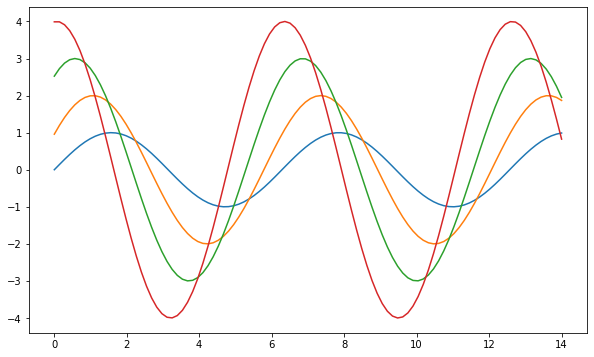

In [24]:
x = np.linspace(0, 14, 100)
y1 = np.sin(x)
y2 = 2 * np.sin(x + 0.5)
y3 = 3 * np.sin(x + 1.0)
y4 = 4 * np.sin(x + 1.5)

plt.figure(figsize=(10,6))
plt.plot(x,y1, x,y2, x,y3, x,y4)
plt.show()

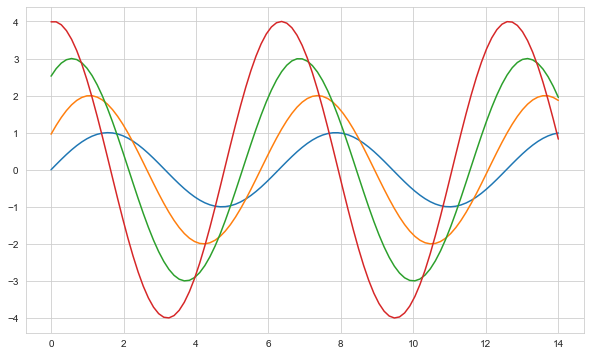

In [25]:
sns.set_style('whitegrid')

plt.figure(figsize=(10,6))
plt.plot(x,y1, x,y2, x,y3, x,y4)
plt.show()

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

Tips라는 데이터셋인데요, 요일별 점심, 저녁, 흡연 여부와 식사 금액과 팁을 정리한 데이터입니다.

In [27]:
tips = sns.load_dataset('tips')
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


### boxplot
boxplot을 그리는데 x축에는 요일로, y축에는 전체 금액을 그릴수 있습니다.

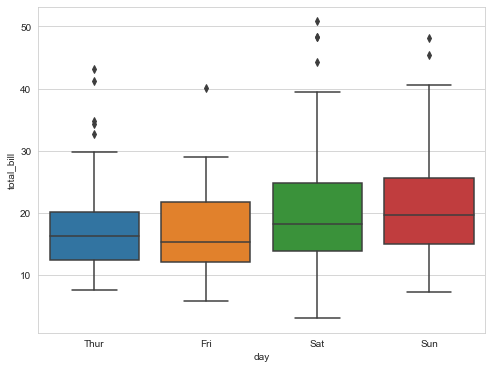

In [28]:
plt.figure(figsize=(8,6))
sns.boxplot(x='day', y='total_bill', data=tips)
plt.show()

hue라는 옵션을 이용해서 구분할 수 있습니다.

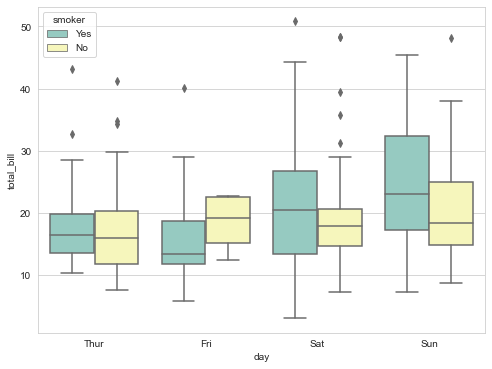

In [29]:
plt.figure(figsize=(8,6))
sns.boxplot(x='day', y='total_bill', data=tips, hue='smoker', palette='Set3')
plt.show()

### lmplot
데이터를 scatter처럼 그리고 직선으로 regression한 그림도 같이 그려주고 유효범위도 ci로 잡아줍니다.

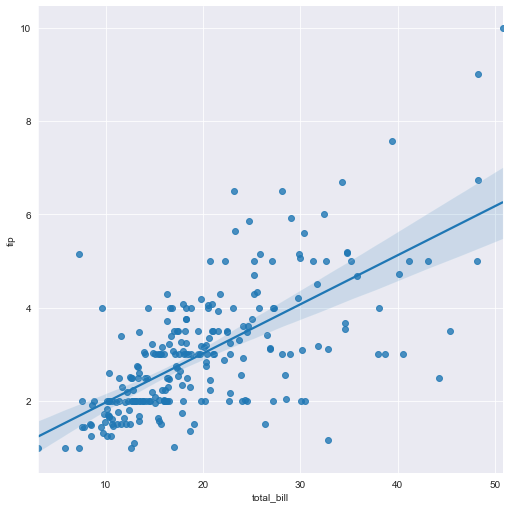

In [30]:
sns.set_style('darkgrid')
sns.lmplot(x='total_bill', y='tip', data=tips, size=7)
plt.show()

lmplot도 hue 옵션을 가질 수 있으며 미리 준비된 palette로 색상을 지정할 수 있습니다.

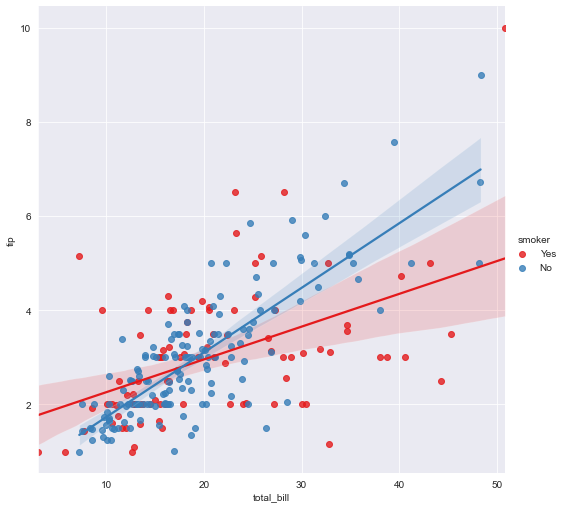

In [31]:
sns.lmplot(x='total_bill', y='tip', data=tips, size=7, hue='smoker', palette='Set1')
plt.show()

이번에는 연도 및 월별 항공기 승객수를 기록한 데이터를 가져오겠습니다.

In [32]:
flights = sns.load_dataset('flights')
flights.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


pivot 기능으로 간편하게 월별, 연도별로 구분할 수 있습니다.

In [33]:
flights = flights.pivot('month', 'year', 'passengers')
flights.head()

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
Jan,112,115,145,171,196,204,242,284,315,340,360,417
Feb,118,126,150,180,196,188,233,277,301,318,342,391
Mar,132,141,178,193,236,235,267,317,356,362,406,419
Apr,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472


### heatmap
heatmap 이라는 도구를 이용하면 이런 종류의 데이터는 그 경향을 설명하기 참 좋습니다.

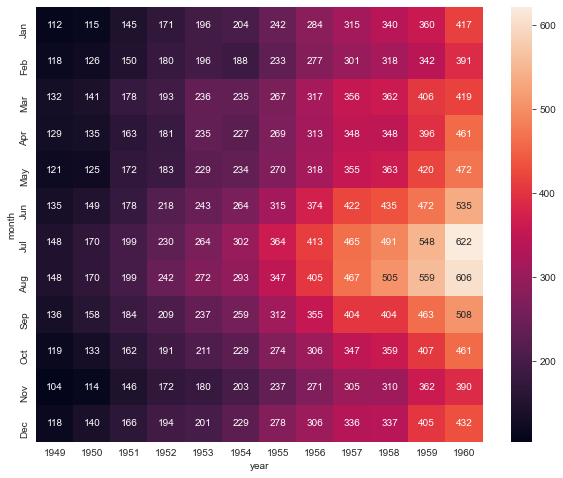

In [34]:
plt.figure(figsize=(10,8))
sns.heatmap(flights, annot=True, fmt='d')
plt.show()

이번에는 머신러닝에서 중요하게 다뤄지는 아이리스 꽃에 대한 데이터를 가지고 옵니다.

In [35]:
sns.set(style='ticks')
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


꽃잎, 꽃받침의 너비와 폭을 가지고 그 종을 구분할 수 있는지를 알아보겠습니다.

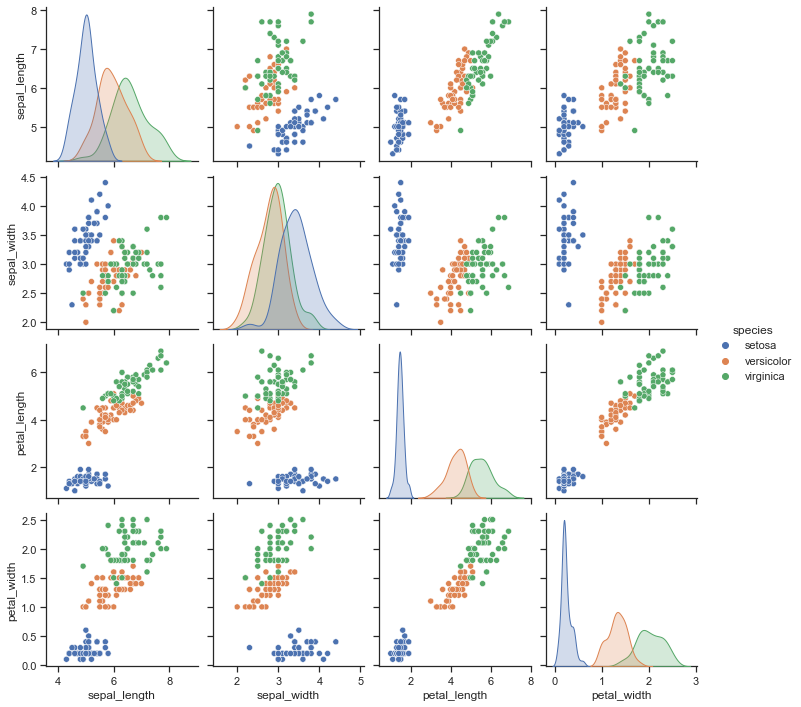

In [36]:
sns.pairplot(iris, hue='species')
plt.show()

## 2-8 범죄 대이터 시각화하기

In [37]:
import platform
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('fonr', family='AppleGothic')
elif platform.system() == 'Windows':
    path = 'c:/windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

pairplot으로 강도, 살인, 폭력 간의 상관관계를 그래프로 보겠습니다.

강도와 폭력, 살인과 폭력, 강도와 살인 모두 양의 상관관계가 보입니다.

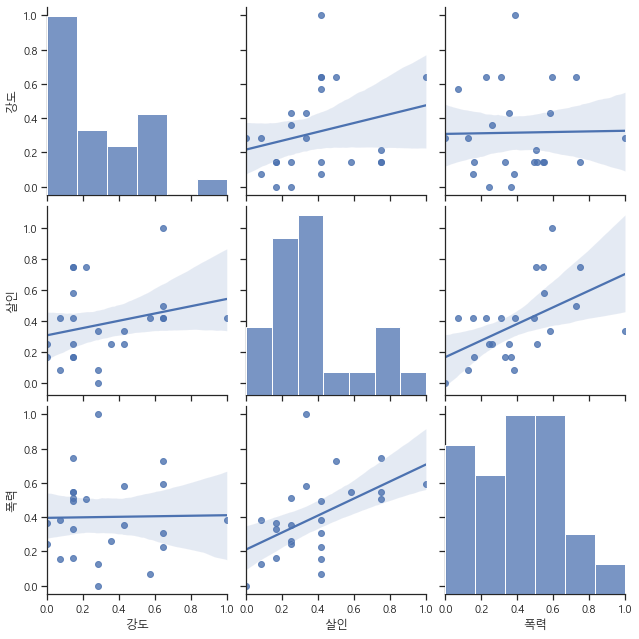

In [38]:
sns.pairplot(crime_normalize, vars=['강도', '살인', '폭력'], kind='reg', size=3)
plt.show()

전체적인 상관계수는 CCTV와 살인의 관계가 낮을지 몰라도 CCTV가 없을 때 살인이 많이 일어나는 구간이 있습니다. 즉, CCTV 개수를 기준으로 좌측면에 살인과 강도의 높은 수를 갖는 데이터가 보입니다.

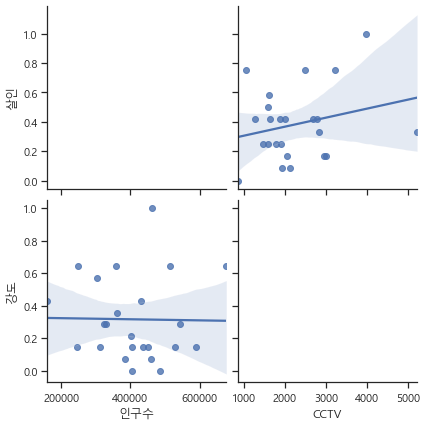

In [39]:
sns.pairplot(crime_normalize, 
    x_vars=['인구수', 'CCTV'], 
    y_vars=['살인', '강도'], 
    kind='reg', size=3)
plt.show()

그런데 살인 및 폭력 검거율과 CCTV의 관계가 양의 상관관계가 아닙니다. 오히려 음의 상관계수도 보입니다. 또 인구수와 살인 및 폭력 검거율도 음의 상관관계가 관찰 됩니다.

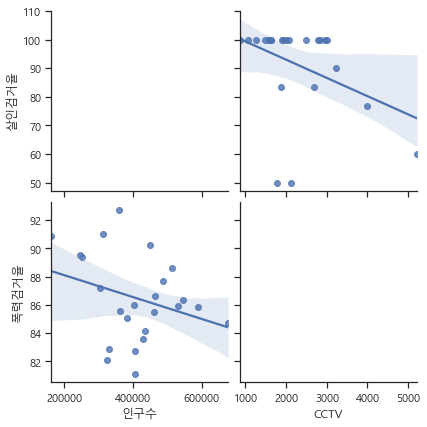

In [40]:
sns.pairplot(crime_normalize, 
    x_vars=['인구수', 'CCTV'], 
    y_vars=['살인검거율', '폭력검거율'], 
    kind='reg', size=3)
plt.show()

검거율의 합계인 검거 항목 최고 값을 100으로 한정하고 그 값으로 정렬한 다음, hitmap을 그려보겠습니다.

In [41]:
tmp_max = crime_normalize['검거'].max()
crime_normalize['검거'] = crime_normalize['검거'] / tmp_max * 100
crime_normalize_sort = crime_normalize.sort_values(by='검거', ascending=False)
crime_normalize_sort.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
구별,,,,,,,,,,,,,,
종로구,0.256944,0.428571,0.250000,0.332569,0.352506,100.000000,100.0,100.0,70.561056,90.874159,159842,1471,1.620591,100.000000
은평구,0.180556,0.000000,0.166667,0.355505,0.366886,83.505155,100.0,100.0,62.428115,87.718470,485842,2962,1.069613,93.978900
성북구,0.149306,0.142857,0.166667,0.133945,0.159819,73.863636,100.0,100.0,67.560074,90.266584,449871,3003,0.752594,93.553825
용산구,0.315972,0.142857,0.166667,0.095872,0.333607,87.132353,100.0,100.0,54.454454,89.538310,244953,2063,1.054975,93.431343
도봉구,0.000000,0.285714,0.000000,0.000000,0.000000,92.222222,100.0,100.0,49.873418,82.843137,329300,858,0.285714,92.090669


결과를 보면 절도 검거율은 다른 검거율에 비해 낮다는 것을 알 수 있습니다.

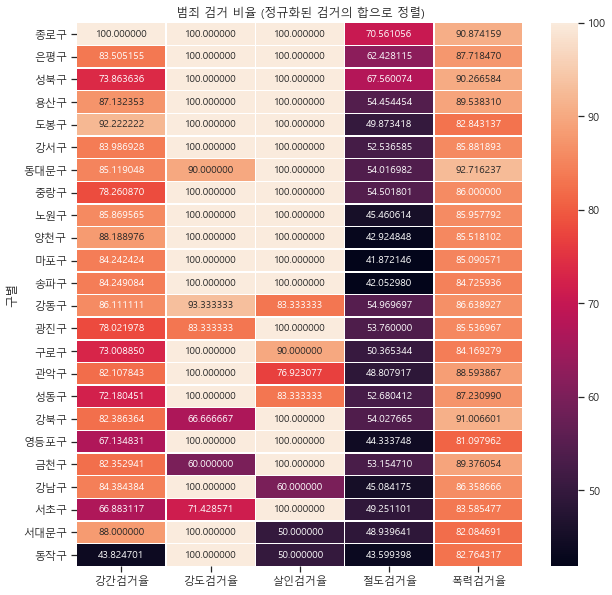

In [42]:
target_col = ['강간검거율', '강도검거율', '살인검거율', '절도검거율', '폭력검거율']
crime_normalize_sort = crime_normalize.sort_values(by='검거', ascending=False)

plt.figure(figsize=(10,10))
sns.heatmap(crime_normalize_sort[target_col], annot=True, fmt='f', linewidths=.5)
plt.title('범죄 검거 비율 (정규화된 검거의 합으로 정렬)')
plt.show()

이번에는 발생 건수의 합으로 정렬해서 heatmap으로 관찰 해보겠습니다. 발생 건수로 보니 '강남구', '관악구', '서초구'가 범죄 발생 건수가 높습니다.

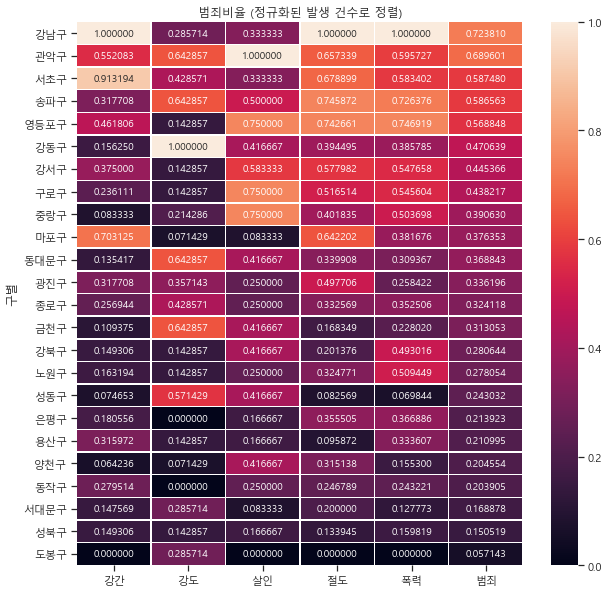

In [43]:
target_col = ['강간', '강도', '살인', '절도', '폭력', '범죄']

crime_normalize['범죄'] = crime_normalize['범죄'] / 5
crime_normalize_sort = crime_normalize.sort_values(by='범죄', ascending=False)

plt.figure(figsize=(10,10))
sns.heatmap(crime_normalize_sort[target_col], annot=True, fmt='f', linewidths=.5)
plt.title('범죄비율 (정규화된 발생 건수로 정렬)')
plt.show()

In [44]:
import modules.fs as fs
importlib.reload(fs)

fs.to_parquet(crime_normalize, path='./data/crime_in_seoul_final.parquet')

## 2-9 지도 시각화 도구 - Folium

In [45]:
import folium

위도와 경도 정보를 주면 지도를 그려줍니다. 마이크로소프트의 익스플로러 브라우저에서는 지도가 파일로 저장은 되는데 브라우저에 저렇게 표현되지는 않습니다.

In [46]:
map_osm = folium.Map(location=[45.5236, -122.6750])
map_osm

zoom_start라는 옵션으로 확대 비율을 정의할 수도 있습니다.

In [47]:
stamen = folium.Map(location=[45.5236, -122.6750], zoom_start=13)
stamen

tiles옵션으로 저런 모양의 지도도 만들 수 있습니다.

In [48]:
stamen = folium.Map(location=[45.5236, -122.6750], zoom_start=13, tiles='Stamen Toner')
stamen

지도를 그리고 그 상태에서 원하는 좌표(위도,경도)에 Marker 명령으로 마크를 찍을 수 있습니다. 그리고 CircleMarker 명령으로 반경(radius)과 색상(color)을 지정하면 원을 그려줍니다.

In [49]:
map_2 = folium.Map(location=[45.5236, -122.6750], zoom_start=13, tiles='Stamen Toner')
folium.Marker([45.5244, -122.6699], popup='The Waterfront').add_to(map_2)
folium.CircleMarker([45.5215, -122.6261], 
    radius=50, 
    popup='Laurelhurst Park', 
    color='#3186cc', 
    fill_color='#3186cc',
).add_to(map_2)
map_2

In [50]:
import folium
import pandas as pd

### colormap

json 파일에는 id로 주별 고유 ID, 그리고 주 이름 등의 좌표가 있습니다. 특히 지도를 그리기 위해 주 경계선을 일일이 위도 경도 좌표가 입력되어 있어서 그걸따라 선을 그리면 주 경계선이 됩니다.

In [51]:
import modules.fs as fs
importlib.reload(fs)

state_data = fs.read_csv(path='./data/02.folium_US_Unemployment_Oct2012.csv')
state_data.head()

state_geo = './data/02.folium_us-states.json'

mapping = folium.Map(location=[40, -98], zoom_start=4)
mapping.choropleth(geo_data=state_geo, 
    data=state_data, 
    columns=['State', 'Unemployment'],
    key_on='feature.id',
    fill_color='YlGn',
    legend_name='Unemployment Rate (%)')

mapping

## 2-10 서울시 범죄율에 대한 지도 시각화

In [52]:
import json
geo_path = './data/02.skorea_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

서울시의 중심의 위도와 경도 정보를 먼저 입력하고 경계선을 그리는데, 컬러맵은 살인 발생 건수로 지정합니다.

In [53]:
mapping = folium.Map(location=[37.5502, 126.982], zoom_start=11, tiles='Stamen Toner')
mapping.choropleth(geo_data=geo_str, 
    data=crime_normalize['살인'], 
    columns=[crime_normalize.index, crime_normalize['살인']], 
    fill_color='PuRd', 
key_on='feature.id')
mapping

In [54]:
강간 발생 건수로 다시 그려보면 강남3구가 안전한지 의심이 듭니다.

SyntaxError: invalid syntax (<ipython-input-54-6fb5e707f975>, line 1)

In [83]:
mapping = folium.Map(location=[37.5502, 126.982], zoom_start=11, tiles='Stamen Toner')
mapping.choropleth(geo_data=geo_str, 
    data=crime_normalize['강간'], 
    columns=[crime_normalize.index, crime_normalize['강간']], 
    fill_color='PuRd', 
key_on='feature.id')
mapping

범죄 발생 건수 전체에 대해 살펴보면, 역시 강남 3구와 강서구 주면이 범죄 발생 건수가 높은 것으로 나타나고 있습니다. 

In [86]:
mapping = folium.Map(location=[37.5502, 126.982], zoom_start=11, tiles='Stamen Toner')
mapping.choropleth(geo_data=geo_str, 
    data=crime_normalize['범죄'], 
    columns=[crime_normalize.index, crime_normalize['범죄']], 
    fill_color='PuRd', 
key_on='feature.id')
mapping

그러나 인구수를 고려해야 할 것 같습니다. 즉 인구 대비 범죄 발생 비율을 알아보는 것입니다. 그래서 범죄 전체 발생 건수에 인구수를 나누고 소수점 밑으로 가서 적절한 값을 곱하는 것으로 하겠습니다.

인구 대비 범되 발생 건수로 보면 강남 3구가 1위는 아니지만 안전도가 제일 높다고 말할 수는 없을것 같습니다.

In [87]:
tmp_criminal = crime_normalize['살인'] / crime_normalize['인구수'] * 1000000

mapping = folium.Map(location=[37.5502, 126.982], zoom_start=11, tiles='Stamen Toner')
mapping.choropleth(geo_data=geo_str, 
    data=crime_normalize['범죄'], 
    columns=[crime_normalize.index, tmp_criminal], 
    fill_color='PuRd', 
key_on='feature.id')
mapping

## 2-11 서울시 경찰서별 검거율과 구별 범죄 발생율을 동시에 시각화하기

경찰서별 검거율과 방금 전까지 수행한 범죄 발생율을 동시에 표현하는 게 효과적일것 같습니다.

In [94]:
crime_and_police.head(1)

,기간,구별,살인발생,살인검거,강도발생,강도검거,강간발생,강간검거,절도발생,절도검거,폭력발생,폭력검거,경찰서,경찰서주소,경찰서주소_x,경찰서주소_y,검거
0,2019,종로구,4,5,7,8,238,1143,1515,1069,2082,1892,서울종로경찰서,서울특별시 종로구 율곡로 46 (경운동),126.984551,37.575876,3.468709


In [101]:
col = ['살인검거', '강도검거', '강간검거', '절도검거', '폭력검거']
tmp = crime_and_police[col] / crime_and_police[col].max()
crime_and_police['검거'] = np.sum(tmp, axis=1)

crime_and_police.head()

,기간,구별,살인발생,살인검거,강도발생,강도검거,강간발생,강간검거,절도발생,절도검거,폭력발생,폭력검거,경찰서,경찰서주소,경찰서주소_x,경찰서주소_y,검거
0,2019,종로구,4,5,7,8,238,1143,1515,1069,2082,1892,서울종로경찰서,서울특별시 종로구 율곡로 46 (경운동),126.984551,37.575876,3.468709
1,2019,용산구,3,3,3,4,272,237,999,544,2036,1823,서울용산경찰서,서울특별시 용산구 원효로89길 24 (원효로1가),126.967648,37.541538,1.776418
2,2019,성동구,6,5,9,10,133,96,970,511,1394,1216,서울성동경찰서,서울특별시 성동구 왕십리광장로 9 (행당동),127.036199,37.562003,2.064835
3,2019,광진구,4,5,6,5,273,213,1875,1008,1853,1585,서울광진경찰서,서울특별시 광진구 자양로 167 (구의동),127.083902,37.542911,2.298036
4,2019,동대문구,6,6,10,9,168,143,1531,827,1977,1833,서울동대문경찰서,서울특별시 동대문구 약령시로21길 15 (청량리동),127.045272,37.584107,2.565839


경찰서의 위치 확인

In [103]:
mapping = folium.Map(location=[37.5502, 126.982], zoom_start=11)

for i in crime_and_police.index:
    folium.Marker([
        crime_and_police['경찰서주소_y'][i],
        crime_and_police['경찰서주소_x'][i]
    ]).add_to(mapping)

mapping

이제 검거에 정당한 값(10)을 곱해서 원 넓이를 정하고, 경찰서의 검거율을 원의 넓이로 표현 하겠습니다. 

이러면 이제 각 경찰서의 위치에서 넓은 원을 가지면 검거율이 높다고 보면 됩니다. 

In [104]:
mapping = folium.Map(location=[37.5502, 126.982], zoom_start=11)

for i in crime_and_police.index:
    folium.CircleMarker([
        crime_and_police['경찰서주소_y'][i],
        crime_and_police['경찰서주소_x'][i]
    ], 
    radius=crime_and_police['검거'][i]*10, 
    color='#3186cc', 
    fill_color='#3186cc').add_to(mapping)

mapping

이제 색상을 붉은 색으로해서 범죄 발생 건수를 넣으면 될 듯합니다.

범죄가 많이 일어날수록 붉은색이고, 그 속에서 검거율이 높을수록 큰 원을 가진 경찰서들이 배치 됩니다. 그러면 서울 서부는 범죄는 많이 발생하지만 방어력 또한 높습니다. 서울 강북의 중앙부(중구, 중랑구 등)는 경찰서의 검거율도 높지 않지만, 범죄 발생 건수도 높지 않습니다.

In [105]:
mapping = folium.Map(location=[37.5502, 126.982], zoom_start=11)

mapping.choropleth(geo_data=geo_str, 
    data=crime_normalize['범죄'], 
    columns=[crime_normalize.index, crime_normalize['범죄']], 
    fill_color='PuRd',
    key_on='feature.id')

for i in crime_and_police.index:
    folium.CircleMarker([
        crime_and_police['경찰서주소_y'][i],
        crime_and_police['경찰서주소_x'][i]
    ], 
    radius=crime_and_police['검거'][i]*10, 
    color='#3186cc', 
    fill_color='#3186cc').add_to(mapping)

mapping